# Programming assignment 5: Optimization: Logistic regression

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

## The Task

In this notebook code skeleton for performing logistic regression with gradient descent is given. 
Your task is to complete the functions where required. 
You are only allowed to use built-in Python functions, as well as any `numpy` functions. No other libraries / imports are allowed.

For numerical reasons, we actually minimize the following loss function

$$\mathcal{L}(\mathbf{w}) = \frac{1}{N} NLL(\mathbf{w}) +  \frac{1}{2}\lambda ||\mathbf{w}||^2_2$$

where $NLL(\mathbf{w})$ is the negative log-likelihood function, as defined in the lecture (Eq. 33)

## Load and preprocess the data

We will work with the UCI ML Breast Cancer Wisconsin (Diagnostic) dataset https://goo.gl/U2Uwz2.

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. There are 212 malignant examples and 357 benign examples.

In [12]:
X, y = load_breast_cancer(return_X_y=True)

# Add a vector of ones to the data matrix to absorb the bias term
X = np.hstack([np.ones([X.shape[0], 1]), X])

# Set the random seed so that we have reproducible experiments
np.random.seed(123)

# Split into train and test
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

print(sum(y_train)/len(y_train))

0.6381909547738693


## Task 1: Implement the sigmoid function 

In [4]:
def sigmoid(t):
    """
    Applies the sigmoid function elementwise to the input data.
    
    Parameters
    ----------
    t : array, arbitrary shape
        Input data.
        
    Returns
    -------
    t_sigmoid : array, arbitrary shape.
        Data after applying the sigmoid function.
    """
    # TODO
    return (1/(1+np.exp(-t)))

## Task 2: Implement the negative log likelihood

As defined in Eq. 33

In [5]:
def negative_log_likelihood(X, y, w):
    """
    Negative Log Likelihood of the Logistic Regression.
    
    Parameters
    ----------
    X : array, shape [N, D]
        (Augmented) feature matrix.
    y : array, shape [N]
        Classification targets.
    w : array, shape [D]
        Regression coefficients (w[0] is the bias term).
        
    Returns
    -------
    nll : float
        The negative log likelihood.
    """
    # TODO
    suma=0
    for i in range(len(y)):
        sig=sigmoid(np.matmul(np.transpose(w),X[i]))
        suma+=(y[i]*np.log(sig))+((1-y[i])*np.log(1-sig))
    return(-suma)

### Computing the loss function $\mathcal{L}(\mathbf{w})$ (nothing to do here)

In [6]:
def compute_loss(X, y, w, lmbda):
    """
    Negative Log Likelihood of the Logistic Regression.
    
    Parameters
    ----------
    X : array, shape [N, D]
        (Augmented) feature matrix.
    y : array, shape [N]
        Classification targets.
    w : array, shape [D]
        Regression coefficients (w[0] is the bias term).
    lmbda : float
        L2 regularization strength.
        
    Returns
    -------
    loss : float
        Loss of the regularized logistic regression model.
    """
    # The bias term w[0] is not regularized by convention
    return (negative_log_likelihood(X, y, w) / len(y)) + (lmbda * np.linalg.norm(w[1:])**2)

## Task 3: Implement the gradient $\nabla_{\mathbf{w}}\mathcal{L}(\mathbf{w})$

Make sure that you compute the gradient of the loss function $\mathcal{L}(\mathbf{w})$ (not simply the NLL!)

In [7]:
def get_gradient(X, y, w, mini_batch_indices, lmbda):
    """
    Calculates the gradient (full or mini-batch) of the negative log likelilhood w.r.t. w.
    
    Parameters
    ----------
    X : array, shape [N, D]
        (Augmented) feature matrix.
    y : array, shape [N]
        Classification targets.
    w : array, shape [D]
        Regression coefficients (w[0] is the bias term).
    mini_batch_indices: array, shape [mini_batch_size]
        The indices of the data points to be included in the (stochastic) calculation of the gradient.
        This includes the full batch gradient as well, if mini_batch_indices = np.arange(n_train).
    lmbda: float
        Regularization strentgh. lmbda = 0 means having no regularization.
        
    Returns
    -------
    dw : array, shape [D]
        Gradient w.r.t. w.
    """
    X_Grad=X[mini_batch_indices,:]
    y_Grad=y[mini_batch_indices]
    Gradient=np.zeros_like(w)
    h = 0.001
    for i in range(len(w)):
        Vector_h=np.zeros_like(w)
        Vector_h[i]=h
        Gradient[i]=(compute_loss(X_Grad, y_Grad, w+Vector_h, lmbda)-compute_loss(X_Grad, y_Grad, w-Vector_h, lmbda))/(2*h)
    # TODO
    return Gradient 

### Train the logistic regression model (nothing to do here)

In [8]:
def logistic_regression(X, y, num_steps, learning_rate, mini_batch_size, lmbda, verbose):
    """
    Performs logistic regression with (stochastic) gradient descent.
    
    Parameters
    ----------
    X : array, shape [N, D]
        (Augmented) feature matrix.
    y : array, shape [N]
        Classification targets.
    num_steps : int
        Number of steps of gradient descent to perform.
    learning_rate: float
        The learning rate to use when updating the parameters w.
    mini_batch_size: int
        The number of examples in each mini-batch.
        If mini_batch_size=n_train we perform full batch gradient descent. 
    lmbda: float
        Regularization strentgh. lmbda = 0 means having no regularization.
    verbose : bool
        Whether to print the loss during optimization.
        
    Returns
    -------
    w : array, shape [D]
        Optimal regression coefficients (w[0] is the bias term).
    trace: list
        Trace of the loss function after each step of gradient descent.
    """
    
    trace = [] # saves the value of loss every 50 iterations to be able to plot it later
    n_train = X.shape[0] # number of training instances
    
    w = np.zeros(X.shape[1]) # initialize the parameters to zeros
    
    # run gradient descent for a given number of steps
    for step in range(num_steps):
        permuted_idx = np.random.permutation(n_train) # shuffle the data
        
        # go over each mini-batch and update the paramters
        # if mini_batch_size = n_train we perform full batch GD and this loop runs only once
        for idx in range(0, n_train, mini_batch_size):
            # get the random indices to be included in the mini batch
            mini_batch_indices = permuted_idx[idx:idx+mini_batch_size]
            gradient = get_gradient(X, y, w, mini_batch_indices, lmbda)

            # update the parameters
            w = w - learning_rate * gradient
        
        # calculate and save the current loss value every 50 iterations
        if step % 50 == 0:
            loss = compute_loss(X, y, w, lmbda)
            trace.append(loss)
            # print loss to monitor the progress
            if verbose:
                print('Step {0}, loss = {1:.4f}'.format(step, loss))
    return w, trace

## Task 4: Implement the function to obtain the predictions

In [9]:
def predict(X, w):
    """
    Parameters
    ----------
    X : array, shape [N_test, D]
        (Augmented) feature matrix.
    w : array, shape [D]
        Regression coefficients (w[0] is the bias term).
        
    Returns
    -------
    y_pred : array, shape [N_test]
        A binary array of predictions.
    """
    y_pred=np.zeros_like(X[:,0])
    for i in range(len(y_pred)):
        y_pred[i]=round(sigmoid(np.matmul(np.transpose(w),X[i])),0)
    return y_pred

### Full batch gradient descent

In [10]:
# Change this to True if you want to see loss values over iterations.
verbose = True

In [55]:
n_train = X_train.shape[0]
w_full, trace_full = logistic_regression(X_train, 
                                         y_train, 
                                         num_steps=8000, 
                                         learning_rate=1e-5, 
                                         mini_batch_size=n_train, 
                                         lmbda=0.1,
                                         verbose=verbose)

Step 0, loss = 0.7427
Step 50, loss = 0.9455
Step 100, loss = 0.5152
Step 150, loss = 0.3858
Step 200, loss = 0.3650
Step 250, loss = 0.3491
Step 300, loss = 0.3363
Step 350, loss = 0.3258
Step 400, loss = 0.3169
Step 450, loss = 0.3092
Step 500, loss = 0.3025
Step 550, loss = 0.2965
Step 600, loss = 0.2913
Step 650, loss = 0.2866
Step 700, loss = 0.2823
Step 750, loss = 0.2784
Step 800, loss = 0.2749
Step 850, loss = 0.2717
Step 900, loss = 0.2687
Step 950, loss = 0.2660
Step 1000, loss = 0.2634
Step 1050, loss = 0.2611
Step 1100, loss = 0.2589
Step 1150, loss = 0.2568
Step 1200, loss = 0.2549
Step 1250, loss = 0.2531
Step 1300, loss = 0.2515
Step 1350, loss = 0.2499
Step 1400, loss = 0.2484
Step 1450, loss = 0.2470
Step 1500, loss = 0.2457
Step 1550, loss = 0.2444
Step 1600, loss = 0.2432
Step 1650, loss = 0.2421
Step 1700, loss = 0.2410
Step 1750, loss = 0.2400
Step 1800, loss = 0.2391
Step 1850, loss = 0.2382
Step 1900, loss = 0.2373
Step 1950, loss = 0.2365
Step 2000, loss = 0.235

In [56]:
n_train = X_train.shape[0]
w_minibatch, trace_minibatch = logistic_regression(X_train, 
                                                   y_train, 
                                                   num_steps=8000, 
                                                   learning_rate=1e-5, 
                                                   mini_batch_size=50, 
                                                   lmbda=0.1,
                                                   verbose=verbose)

Step 0, loss = 0.8650
Step 50, loss = 0.3724
Step 100, loss = 0.2750
Step 150, loss = 0.2549
Step 200, loss = 0.2429
Step 250, loss = 0.2483
Step 300, loss = 0.2512
Step 350, loss = 0.2257
Step 400, loss = 0.2241
Step 450, loss = 0.2213
Step 500, loss = 0.2218
Step 550, loss = 0.2196
Step 600, loss = 0.2169
Step 650, loss = 0.2516
Step 700, loss = 0.2150
Step 750, loss = 0.2156
Step 800, loss = 0.2153
Step 850, loss = 0.2127
Step 900, loss = 0.2283
Step 950, loss = 0.2176
Step 1000, loss = 0.2113
Step 1050, loss = 0.2107
Step 1100, loss = 0.2116
Step 1150, loss = 0.2227
Step 1200, loss = 0.2245
Step 1250, loss = 0.2091
Step 1300, loss = 0.2090
Step 1350, loss = 0.2092
Step 1400, loss = 0.2088
Step 1450, loss = 0.2112
Step 1500, loss = 0.2116
Step 1550, loss = 0.2078
Step 1600, loss = 0.2192
Step 1650, loss = 0.2100
Step 1700, loss = 0.2184
Step 1750, loss = 0.2058
Step 1800, loss = 0.2085
Step 1850, loss = 0.2104
Step 1900, loss = 0.2055
Step 1950, loss = 0.2096
Step 2000, loss = 0.205

Our reference solution produces.

    Full batch: accuracy: 0.9240, f1_score: 0.9384
    Mini-batch: accuracy: 0.9415, f1_score: 0.9533

In [57]:
y_pred_full = predict(X_test, w_full)
y_pred_minibatch = predict(X_test, w_minibatch)

print('Full batch: accuracy: {:.4f}, f1_score: {:.4f}'
      .format(accuracy_score(y_test, y_pred_full), f1_score(y_test, y_pred_full)))
print('Mini-batch: accuracy: {:.4f}, f1_score: {:.4f}'
      .format(accuracy_score(y_test, y_pred_minibatch), f1_score(y_test, y_pred_minibatch)))

Full batch: accuracy: 0.9240, f1_score: 0.9384
Mini-batch: accuracy: 0.9357, f1_score: 0.9479


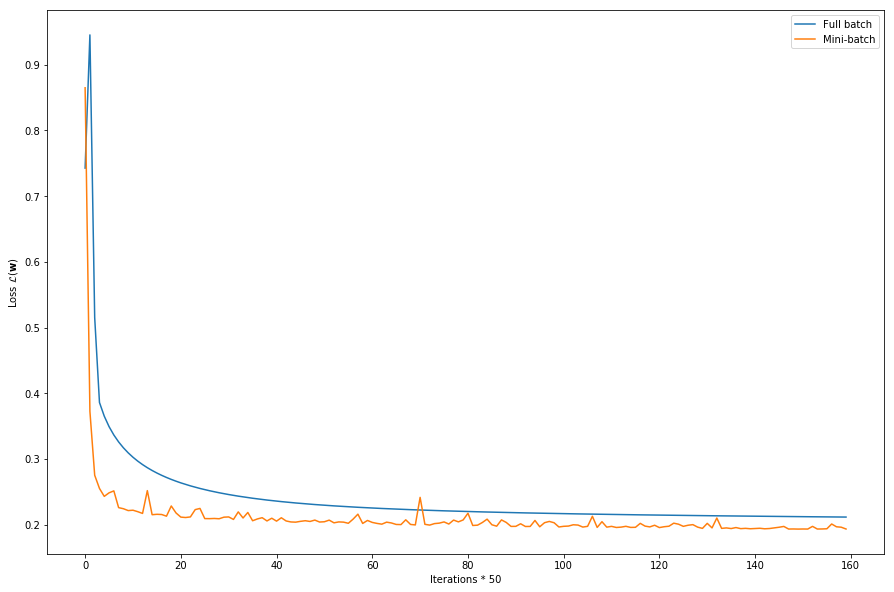

In [58]:
plt.figure(figsize=[15, 10])
plt.plot(trace_full, label='Full batch')
plt.plot(trace_minibatch, label='Mini-batch')
plt.xlabel('Iterations * 50')
plt.ylabel('Loss $\mathcal{L}(\mathbf{w})$')
plt.legend()
plt.show()